<a href="https://colab.research.google.com/github/nandometzger/MachinePerception/blob/master/4_tensorflow_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Tutorial - CNNs

In this tutorial, you will learn how to build a convolutional neural network (CNN) for image classification. We will be working with the well-known MNIST dataset featuring hand-written single digits. The CNNs task is then to identify which digit is shown on a given image.

The tutorial is based on the official [TensorFlow example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/mnist/mnist_with_summaries.py). It is meant to teach you the basic tools needed to implement a convolutional architecture in TensorFlow and it additionally shows how to leverage TensorBoard for some visualizations.

In the following, we assume familiarity with the TensorFlow tutorial presented in the previous exercise, i.e., you should be aware of TensorFlow's core concepts, such as graph, session, input placeholders, etc.

This tutorial consists of:
  1. Introduction to CNNs
  2. The MNIST Data Set
  3. Building the Model
  4. TensorBoard
  5. Concluding Remarks and Exercises


## Introduction to CNNs
### The Convolution Operation
A convolution is a mathematical operation and represents an essential building block in image processing tasks. Depending on what filter you use to convolve an image with, you can use convolutions to blur an image (i.e., removing high-frequency noise) ...

<center><img src="https://imgur.com/44GJQA8.png" align="middle" hspace="20px" vspace="5px"></center>

... detect edges ...

<center><img src="https://imgur.com/KIfP80j.png" align="middle" hspace="20px" vspace="5px"></center>

... and [many other things](http://setosa.io/ev/image-kernels/). You can think of a convolution as sliding a window, also called _kernel_ or _filter_, over each pixel of an image and computing a dot product between the filter's values and the image's values that the filter is covering. This operation produces one output value for every location on the image over which we slide the filter. Usually, we go through every pixel in the image and position the filter such that its center pixel lies on the image pixel. Hence, for pixels lying on the boundary of the image, we have to pad the image as the filter otherwise "spills over" (more on this later). A visualization of the convolution process looks like this (this and subsequent animations taken from [here](https://github.com/vdumoulin/conv_arithmetic)):

<center><img src="https://i.imgur.com/pTNYQE7.gif" align="middle" hspace="20px" vspace="5px"></center>

Here, blue is the input image, grey is the 3-by-3 filter that we are convolving the input image with and green is the output image. The dashed pixels represent padded regions.

### Convolutions in Neural Networks
In the context of CNNs, we are using exactly the same convolution operation, but we think of it in a slightly different way: Instead of producing a desired output image like in traditional image processing tasks (e.g. blurry, edges highlighted, etc.), a filter extracts certain _features_ from a local neighborhood and we store them in _feature maps_, sometimes also called _activation maps_ or simply _channels_. Moreover, we are moving several filters over a given image, so each convolutional layer potentially outputs several of those feature maps. Importantly, the weights of the filter are not fixed - those values are actually what the network must optimize. In other words, the network learns to set up those filters in such a way that they extract features from the images that are most useful for the network to solve the task at hand.

The following animation taken from the lecture slides summarizes all this:

<img src="https://imgur.com/JpUiKVQ.gif" align="middle" hspace="20px" vspace="5px">

### Types of Convolutions
When adding a convolutional layer, we must decide upon the following:
  - **Filter Size**: We have to decide how big a filter is, i.e. determine its width and height. Common choices are  small, square, and odd, e.g. 3-by-3, 5-by-5, 7-by-7, etc. Of course, this depends on the problem you are trying to solve. Increasing the filter sizes increases the amount of trainable parameters. CNNs are every effective models thanks to **weight-sharing** and **repetition of convolution operation**, which also provides invariance to certain image operations such as translation and rotation. The parameter space can be reduced considerably in comparison to fully connected layers. Choosing huge filter sizes goes against this intuition, and in recent research it was shown, that instead of increasing filter sizes, creating deeper models is generally a better idea.
  - **Number of Feature Maps**: We should also decide how many feature maps each layer outputs. Again, this design choice depends on the problem.
  - **Padding**: As mentioned above, when we apply the filter on the boundary of the image, the filter "spills over". Hence, we must decide what to do in these cases. TensorFlow knows two options: _VALID_ or _SAME_. When we choose _VALID_ the filter will only be placed on pixels where it does not "spill over" the boundary. This means, that the output image will _not_ have the same size as the input image. On the other hand _SAME_ applies just enough padding that the output image will be the same size as the input (if the stride is 1).
  - **Strides**: So far we always assumed that once we computed the output of a filter at a given location, we just move on the pixel right next to it. We could however also choose to omit some pixels inbetween. E.g., if we were to compute the convolution only on every other pixel, we would say that we use a stride of 2. This effectively reduces the size of the output image. Sometimes strided convolutions are used instead of pooling layers. The following example shows a convolution with the stride set to 2 on both the vertical and the horizontal axis of the image.
  <center><img src="https://imgur.com/kjgc33A.gif" align="middle" hspace="20px" vspace="5px"></center>
  
  - **Dilations**: In dilated convolutions, sometimes also called "à trous", we introduce holes in the filter, i.e. we spread the filter over a wider area but without considering some pixels inside that area in the computation of the dot product. This allows for a **faster growth of the receptive field** in deeper layers than with standard convolutions. The intuition behind is that it is easier to integrate global context into the convolution operation. The following example shows a dilated convolution with a dilation factor of 2 on both the vertical and horizontal axis of the image.
<center><img src="https://imgur.com/CVVof0p.gif" align="middle" hspace="20px" vspace="5px"></center>



### Building Blocks of a CNN
CNNs built for classification tasks typically make use the following types of layers:
  - **Convolutional Layers**: Layers implementing the actual convolution as explained above. Their outputs are feature maps which are then passed through an activation function in order to introduce non-linearities into the system. Convolutional layers can be seen as extracting features that are passed on deeper into the model thus enabling the model to learn higher-level features that maket he classification task easier.
  - **Pooling Layers**: Downsampling or pooling layers concentrate the information so that deeper layers focus more on abstract/high-level patterns. You can apply strided convolutions to apply downsampling. A decreased image size also speeds up the processing time in general because less convolutions are necessary on subsequent layers. Furthermore, pooling allows for some translation invariance on the input. A common choice is max-pooling, where only the maximum value occurring in a certain region is propagated to the output.
  - **Dense Layers**: A dense or fully-connected layer connects every node in the input to every node in the output. This is the type of layer you already used for the linear regression model in the previous tutorial. If the input dimension is large, the amount of learnable parameters introduced by using a dense layer can quickly explode. Hence, dense layers are usually added on deeper levels of the model, where the pooling operations have already reduced the dimensionality of the data. Typically, the dense layers are added last in a classification model, performing the actual classification on the features extracted by the convolutional layers.
  
As an example, here is the architecture overview of the VGG16 model ([source](https://www.safaribooksonline.com/library/view/machine-learning-with/9781786462961/21266fa5-9e3b-4f9e-b3c6-2ca27a8f8c12.xhtml)).

<center><img src="https://imgur.com/sc9tqx6.png" align="middle" hspace="20px" vspace="5px"></center>

## The MNIST Data Set
With this brief recap of convolutional architectures, we are now ready to tackle the problem of hand-written digit classification from images. Let's first have a look at the contents of the MNIST data set. To do so, let's import all the libraries we need for this tutorial and define some useful helper functions.

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from tensorflow.examples.tutorials.mnist import input_data

# Tensorboard in Colab environment.
!pip install tensorboardcolab
from tensorboardcolab import *
tbc = TensorBoardColab()

# Visit the URL below after Tensorboard section.

Using TensorFlow backend.


Wait for 8 seconds...
TensorBoard link:
http://1d74aa76.ngrok.io


In [0]:
def plot_images(images, cls_true, cls_pred=None):
    """Plot 9 MNIST sample images in a 3x3 sub-plot."""
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i,ax in enumerate(axes.flat):
      # Plot image.
      ax.imshow(images[i].reshape(img_shape), cmap='binary')

      # Show true and predicted classes.
      if cls_pred is None:
          xlabel = "True: {0}".format(cls_true[i])
      else:
          xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

      ax.set_xlabel(xlabel)

      # Remove ticks 
      ax.set_xticks([])
      ax.set_yticks([])

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/tensorflow/mnist_cnn/logs/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/tensorflow/mnist_cnn/logs/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/tensorflow/mnist_cnn/logs/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/tensorflow/mnist_cnn/logs/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


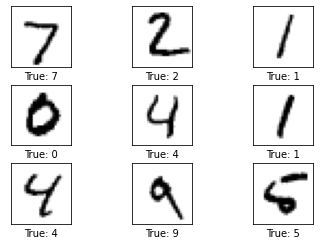

In [0]:
# Import the data
log_dir = "/tmp/tensorflow/mnist_cnn/logs"
mnist = input_data.read_data_sets(log_dir, one_hot=False, fake_data=False)

# We know that MNIST images are 28 pixels in each dimension.
img_size = 28
# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size
# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)
# Images are gray-scale, so we only have one image channel
num_image_channels = 1
# Number of classes, one class for each of 10 digits.
num_classes = 10

# Print some stats
print("Size of:")
print("- Training-set:\t\t{}".format(len(mnist.train.labels)))
print("- Test-set:\t\t{}".format(len(mnist.test.labels)))
print("- Validation-set:\t{}".format(len(mnist.validation.labels)))

# Get some sample images from the test set.
images = mnist.test.images[0:9]

# Get the true classes for those images.
cls_true = mnist.test.labels[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## Building the Model
Let's now have a look at the core of this tutorial, namely how to build the actual CNN that is trained to predict the hand-written number on 28-by-28 gray-scale images. To begin with, when you build a model there are usually some design choices and hyper-parameters that you want to experiment with. Hence, it is good practice to make those parameters configurable through the command line or an external configuration file. TensorFlow provides  built-in support for this, called `FLAGS`, so let's define some of those: 

In [0]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

tf.app.flags.DEFINE_string("log_dir", log_dir, "Summaries log directory")
tf.app.flags.DEFINE_string("feature_map_sizes", "32,64,128", "Number of layers to be used and number of feature maps per layer")
tf.app.flags.DEFINE_string("filter_sizes", "5,5,5", "Size of square filters per layer")
tf.app.flags.DEFINE_float("learning_rate", 1e-3, "Learning rate (default: 1e-3)")
tf.app.flags.DEFINE_integer("batch_size", 128, "Batch size (default: 128)")
tf.app.flags.DEFINE_integer("max_steps", 10000, "Number training steps/iterations (default: 1000)")
tf.app.flags.DEFINE_integer("evaluate_every_step", 250, "Evaluate model on validation set after this many steps/iterations (i.e., batches) (default: 50)")
tf.app.flags.DEFINE_string('f', '', 'kernel')  # Dummy entry so that colab doesn't complain.

In [0]:
FLAGS = tf.app.flags.FLAGS
print("\nCommand-line Arguments:")
for key in FLAGS.flag_values_dict():
  print("{:<22}: {}".format(key.upper(), FLAGS[key].value))
print("")


Command-line Arguments:
LOG_DIR               : /tmp/tensorflow/mnist_cnn/logs
FEATURE_MAP_SIZES     : 32,64,128
FILTER_SIZES          : 5,5,5
LEARNING_RATE         : 0.001
BATCH_SIZE            : 128
MAX_STEPS             : 10000
EVALUATE_EVERY_STEP   : 250
F                     : 



We define some functions that allow us to create `tf.Variables`. Remember that TensorFlow variables are just special tensors, that retain their value across different runs of the graph. Additionally, they are trainable, i.e., the optimizer will change their values during backpropagation, so in the end they represent all the trainable parameters of the model that we want to optimize for.

In [0]:
def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    # Initialize variable by drawing from a Gaussian distribution.
    # Here, another popular choice is the use Xavier initializers.t
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    return tf.Variable(tf.constant(0.1, shape=shape))

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor for TensorBoard visualizations."""
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Using these functions, we can now define the core of our model. Note that the following functions just create nodes in the computational graph, no actual computation is taking place just yet.

In [0]:
def dense_layer(input_tensor, output_dim, layer_name, act=tf.nn.relu):
    """
    Reusable code for making a simple dense layer connected to the last dimension of `input_tensor`.
    It does a matrix multiply, bias add, and then uses an activation to nonlinearize. It also sets
    up name scoping so that the resultant graph is easy to read, and adds a number of summary ops.
    
    :param input_tensor: The input tensor to this layer.
    :param output_dim: The desired output size we want to map to.
    :param layer_name: A name for this layer.
    :param act: Activation function used on the output of the dense layer.
    :return: The activated output of this layer and its weights.
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # Get the input dimensionality
        input_dim = input_tensor.get_shape()[-1].value
        
        # Note that calling `tensor.get_shape()` retrieves the so called static shape of the tensor.
        # The static shape is known at compile time. Some tensor dimensions can be variable, i.e.
        # they are only defined during runtime. To retrieve the dynamic shape, i.e. the shape of
        # a tensor when actually running computations in the graph, we should call `tf.shape(tensor)`
        # instead.
        
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
        return activations, weights
    

def conv_layer(input_layer, filter_size, num_filters, layer_name, use_pooling=True):
    """
    Adds a convolutional layer to `input_layer`. Produces an output tensor of shape
    `[batch_size, input_height/k, input_width/k, num_filters]` where `k = 2` if
    `use_pooling` is activated or 1 otherwise.
    
    :param input_layer: The input to this layer. Expected is a tensor of shape
      `[batch_size, input_height, input_width, input_channels]`
    :param filter_size: Width and height of the filter (scalar).
    :param num_filters: How many feature maps to produce with this layer.
    :param layer_name: A name for this layer.
    :param use_pooling: Use 2x2 max-pooling if True.
    :return: The output of this layer and the filter weights.
    """    
    with tf.name_scope(layer_name):
        # First determine the input channel size
        num_input_channels = input_layer.get_shape()[-1].value
        
        # Shape of the filter-weights for the convolution.
        # This format is determined by the TensorFlow API.
        shape = [filter_size, filter_size, num_input_channels, num_filters]

        # Create new weights aka. filters with the given shape.
        weights = weight_variable(shape=shape)

        # Create new biases, one for each filter.
        biases = bias_variable(shape=[num_filters])

        # Create the TensorFlow operation for convolution.
        # Note the strides are set to 1 in all dimensions.
        # The first and last stride must always be 1,
        # because the first is for the image-number and
        # the last is for the input-channel.
        # But e.g. strides=[1, 2, 2, 1] would mean that the filter
        # is moved 2 pixels across the x- and y-axis of the image.
        # The padding is set to 'SAME' which means the input image
        # is padded with zeroes so the size of the output is the same.
        layer = tf.nn.conv2d(input=input_layer,
                             filter=weights,
                             strides=[1, 1, 1, 1],
                             padding='SAME')

        # Add the biases to the results of the convolution.
        # A bias-value is added to each filter-channel.
        layer += biases

        # Use pooling to down-sample the image resolution?
        if use_pooling:
            # This is 2x2 max-pooling, which means that we
            # consider 2x2 windows and select the largest value
            # in each window. Then we move 2 pixels to the next window.
            layer = tf.nn.max_pool(value=layer,
                                   ksize=[1, 2, 2, 1],
                                   strides=[1, 2, 2, 1],
                                   padding='SAME')

        # Rectified Linear Unit (ReLU).
        # It calculates max(x, 0) for each input pixel x.
        # This adds some non-linearity to the formula and allows us
        # to learn more complicated functions.
        layer = tf.nn.relu(layer)

        # Note that ReLU is normally executed before the pooling,
        # but since relu(max_pool(x)) == max_pool(relu(x)) we can
        # save 75% of the relu-operations by max-pooling first.

        # We return both the resulting layer and the filter-weights
        # because we will plot the weights later.
        return layer, weights

    
def flatten_layer(layer):
    """
    A helper function to flatten the output of a convolutional layer. As a conv layer
    outputs a 4-dimensional tensor, we need to reduce it to 2 dimensions so that
    we can use it as an input the a dense layer.
    
    :param layer: The output of a convolutional layer.
    :return: The input layer flattened to have shape `[batch_size, num_features]`
    """
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [batch_size, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

With this we can now construct the model. The last thing we need to do so, is set up placeholders through which we can feed values into the model. Recall that placeholders are just special tensors for which TensorFlow checks that they have been supplied appropriately when ever running a computation in the graph. Note that the first dimension of each placeholder is `None`. This means that the actual size of that dimension is unknown at compile time and thus can vary at runtime. This is a useful feature especially for the batch size.

In [0]:
# Create input placeholders
with tf.name_scope('input'):
    # This is the format how we read MNIST images.
    images_flat = tf.placeholder(tf.float32, [None, img_size_flat], name='x-input')
    # We reshape this so that we can feed it directly into a conv layer.
    data_placeholder = tf.reshape(images_flat, [-1, img_size, img_size, num_image_channels])
    # Also create a placeholder for the target labels
    label_placeholder = tf.placeholder(tf.int32, [None], name='y-input')

In [0]:
# Extract design parameters from the command line
feature_map_sizes = list(map(int, FLAGS.feature_map_sizes.split(',')))
filter_sizes = list(map(int, FLAGS.filter_sizes.split(',')))
assert len(filter_sizes) == len(feature_map_sizes)

# Build the actual model
next_in = data_placeholder
weights = []
layer_outs = []
for i, (num_out_channels, filter_size) in enumerate(zip(feature_map_sizes, filter_sizes)):
    next_in, w = conv_layer(next_in, filter_size, num_out_channels, 'conv{}_layer'.format(i), use_pooling=True)
    weights.append(w)
    layer_outs.append(next_in)
    
# Flatten the output
out_flat, _ = flatten_layer(next_in)
# Add a dense layer with 10 output neurons, i.e. one for every class from 0-9
logits, _ = dense_layer(out_flat, num_classes, 'dense_layer', act=tf.identity)
probs = tf.nn.softmax(logits)

Note that we did not use an activation function on the output of the dense layer. Generally speaking, it is not always reasonable to use an activation function on the last layer, depending on the distribution of your outputs. For example, if you used a `tf.nn.tanh` activation on your output layer, all outputs would come to lie between -1 and 1. While an activation function on the outputs is a trick to define the output range for free, it is inherently biased. In other words, the distribution of output values does not match with the shape of the activation function. Depending on your problem, this might or might not make sense. 

For our case, we want the outputs of the model to be probabilities, i.e., the model should tell us what is the probability that a certain image belongs to each of the 10 classes. For this, we can use the softmax activation function, defined as follows:

$$
\sigma(\mathbf{z})_j = \frac{e^{\mathbf{z}_j}}{\sum_{k=1}^K e^{\mathbf{z}_k}}
$$

where $\mathbf{z}$ is our $K$-dimensional output vector `logits` and $K$ refers to the number of classes that we are trying to predict, i.e. $K=10$ in our case. The softmax function essentially squashes its input between 0 and 1 and makes sure that all $K$ values sum up to 1. In other words, it produces a valid probability distribution over the number of classes.

<center><img src="https://imgur.com/te7R6BW.png" align="middle" hspace="20px" vspace="5px"></center>

So, how come we did not supply `tf.nn.softmax` to our dense layer above? The reason is that when we feed softmax-activated values to our loss function, we introduce numerical instabilities that destabilize the training. The loss function measures how good the prediction of our network is. Ideally, if we feed an image depicting a hand-written 3 to our model, we want it to assign a probability of 1 to the class 3 and probabilities of 0 to all other classes. Thus, for every image we have a target distribution $q$, which is just a one-hot encoding of its label, and an estimated probability distribution $p$ which is the output of the model. A one-hot encoding of a label is simply a vector of zeros that has exactly one entry showing 1 corresponding to the index of that label. For example, the one-hot encoding of label 3 looks like this:

$$
\left[0, 0, 0, 1, 0, 0, 0, 0, 0, 0 \right]^T \in \mathbb{R}^{10}
$$

The only thing left is now to find a measure of the distance between those two distributions, i.e. how closely $p$ resembles the one-hot encoding $q$. For this, we can use the cross-entropy:

$$
H(p, q) = H(p) + D_{KL}(p || q) = -\sum\limits_x p(x) \log q(x)
$$

where $H(p)$ is the entropy of $p$ and $D_{KL}$ is the Kullback-Leibler Divergence. You can see from this formula that if the predicted probability $p$ is exactly a one-hot encoding, $H(p, q)$ will be 0, because the entropy $H(p)$ of a one-hot vector is 0 and the KL divergence will also be 0 because $p$ exactly matches $q$.

The problem with the cross-entropy, as mentioned before, is that it is numerically unstable and can produce `inf` values during training. Hence, TensorFlow produces a more stable version which takes as input the logits, _not_ the softmax activated values. This is why we did not choose an activation function for the outputs of the dense layer.

In [0]:
# Loss: Cross-Entropy
with tf.name_scope('cross_entropy'):
    # So here we use tf.nn.softmax_cross_entropy_with_logits on the
    # raw outputs of the nn_layer above, and then average across
    # the batch.
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label_placeholder))
    tf.summary.scalar('cross_entropy_loss', cross_entropy_loss)

Now that we defined the model and the loss, we must also choose the optimizer. Before doing so, it might be a good idea to check how many trainable parameters we've created with the model definition above. This is both a sanity check and also gives you an intuition about the capacity of the model.

In [0]:
def count_trainable_parameters():
    """Counts the number of trainable parameters in the current default graph."""
    tot_count = 0
    for v in tf.trainable_variables():
        v_count = 1
        for d in v.get_shape():
            v_count *= d.value
        tot_count += v_count
    return tot_count
print("Number of trainable parameters: {}".format(count_trainable_parameters()))

Number of trainable parameters: 277514


With this, it is time to define our optimizer.

In [0]:
# Create a variable to contain a counter for the global training step.
global_step = tf.Variable(1, name='global_step', trainable=False)

# Optimization operation: SGD (Stochastic Gradient Descent)
with tf.name_scope('train'):
    # This operation automatically increases the `global_step` by 1 every time it is called
    train_step = tf.train.GradientDescentOptimizer(FLAGS.learning_rate).minimize(
        cross_entropy_loss, global_step=global_step)    

In [0]:
# Additionally want to monitor the accuracy of the training, not just the cross-entropy value.
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_predictions'):
        #predictions = tf.argmax(logits, 1, name="predictions")
        correct_predictions = tf.nn.in_top_k(logits, label_placeholder, 1)
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

At this point we are almost ready to start the training. The only thing left to do is start the session (hopefully on the GPU), add some helper functions to feed data into the model and prepare some summary writers so that we can monitor the progress in TensorBoard.

In [0]:
# Create the session
sess = tf.InteractiveSession()

# Tensorboard
train_writer = tbc.get_deep_writers("single_layer_model/train")
train_writer.add_graph(sess.graph)
valid_writer = tbc.get_deep_writers("single_layer_model/valid")
valid_writer.add_graph(sess.graph)

# Initialize all variables
sess.run(tf.global_variables_initializer())

# To be able to see something in tensorboard, we must merge summaries to one common operation.
# Whenever we want to write summaries, we must request this operation from the graph.
# Note: creating the file writers should happen after the session was launched.
summaries_merged = tf.summary.merge_all()

In [0]:
def feed_dict(train_mode):
    """Make a TensorFlow feed_dict: maps data onto placeholders."""
    if train_mode:
        xs, ys = mnist.train.next_batch(FLAGS.batch_size)
    else:
        xs, ys = mnist.validation.images, mnist.validation.labels
    return {images_flat:xs, label_placeholder:ys}

def do_train_step(num_steps, summary_op):
    """Perform as many training steps as specified and may be evaluate on validation set."""
    for i in range(num_steps):
        step = tf.train.global_step(sess, global_step)
        if step % FLAGS.evaluate_every_step == 0:
            # Record summaries and test-set accuracy
            summary, acc_valid = sess.run([summary_op, accuracy], feed_dict=feed_dict(False))
            valid_writer.add_summary(summary, step)
            print('[{}] Accuracy Training [{:.3f}], Validation [{:.3f}]'.format(step, acc_valid, acc_train)) 

        # Record train set summaries, and train
        summary, acc_train, _ = sess.run([summary_op, accuracy, train_step], feed_dict=feed_dict(True))
        train_writer.add_summary(summary, step)

Now let's train this model for a couple of steps. 

In [0]:
do_train_step(1001, summaries_merged)
train_writer.flush()
valid_writer.flush()

[250] Accuracy Training [0.768], Validation [0.750]
[500] Accuracy Training [0.855], Validation [0.820]
[750] Accuracy Training [0.885], Validation [0.883]
[1000] Accuracy Training [0.906], Validation [0.906]


You will see training loss, distribution of weight & bias parameter values and our graph.

You can see that the accuracy on the validation set steadily increases. Sometimes it might be interesting to see some visualizations of the learned convolutional filter weights or the outputs of layer. Let's define some helper functions to do that.

In [0]:
def plot_conv_weights(session, weights, input_channel=0):
    """Helper-function for plotting convolutional weights."""
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
    
def plot_conv_layer(layer, image):
    """Helper-function for plotting the output of a convolutional layer."""
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {images_flat: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = sess.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]
            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

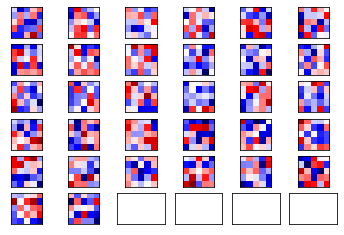

In [0]:
plot_conv_weights(sess, weights=weights[0])

Because we trained the model only for a few epochs, the validation accuracy is not overwhelming. Let's train more.

In [0]:
do_train_step(10000, summaries_merged)
plot_conv_weights(sess, weights=weights[0])

[1250] Accuracy Training [0.919], Validation [0.922]
[1500] Accuracy Training [0.927], Validation [0.922]
[1750] Accuracy Training [0.935], Validation [0.953]
[2000] Accuracy Training [0.939], Validation [0.945]
[2250] Accuracy Training [0.942], Validation [0.961]
[2500] Accuracy Training [0.946], Validation [0.922]
[2750] Accuracy Training [0.946], Validation [0.945]
[3000] Accuracy Training [0.950], Validation [0.961]
[3250] Accuracy Training [0.949], Validation [0.953]
[3500] Accuracy Training [0.954], Validation [0.930]
[3750] Accuracy Training [0.956], Validation [0.930]
[4000] Accuracy Training [0.956], Validation [0.953]
[4250] Accuracy Training [0.957], Validation [0.961]
[4500] Accuracy Training [0.958], Validation [0.977]
[4750] Accuracy Training [0.961], Validation [0.953]
[5000] Accuracy Training [0.961], Validation [0.984]
[5250] Accuracy Training [0.963], Validation [0.953]
[5500] Accuracy Training [0.962], Validation [0.977]
[5750] Accuracy Training [0.964], Validation [

Once you trained the model for a longer period of time, you should achieve a validation accuracy of above 95 %. Next, we can look at how the model performs on some examples taken from the test set.

In [0]:
# Feed some test images into the model and get the predicted label
test_images = mnist.test.images[0:9]

# Get the true classes for those images.
test_cls_true = mnist.test.labels[0:9]

# Feed the images into the model and get the predictions
feed_dict = {images_flat: test_images}
logits_np = sess.run(logits, feed_dict)


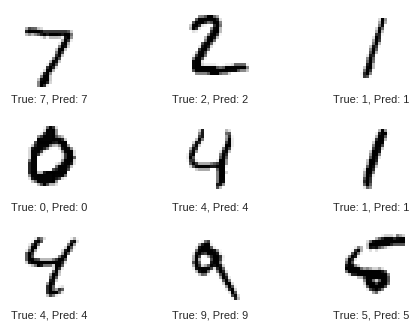

In [0]:
# logits_np has shape [9, 10], find the class with the highest probability for each
test_cls_predicted = np.argmax(logits_np, axis=-1)

# then visualize
plot_images(test_images, test_cls_true, test_cls_predicted)

Assuming the model was trained for long enough, you should now see that the model has performed quite well on these 9 images.

May be for a certain image, you are also interested in visualizing the output of a convolutional layer, i.e. its resulting feature maps. For the first image in the test data set, i.e. the one showing number 7 in the above plot, this would look like follows:

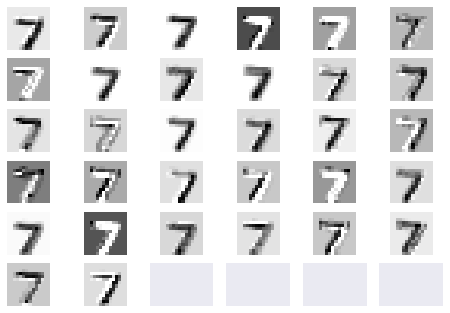

In [0]:
plot_conv_layer(layer_outs[0], mnist.test.images[0])

That's it - we've successfully trained a convolutional neural network for classification of hand-written digits. Lastly, let's not forget to clean up after us.

In [0]:
# cleanup
sess.close()

## TensorBoard
The most important one being the `accuracy` measurement. In this plot we see that the accuracy on both the validation and training set behave very similarly, which is what we want. If you would observe that the validation accuracy is again going down after some time, while the training accuracy keeps improving, this would be a strong indication that the model is overfitting.

Another trend we see from this plot is that accuracy quickly improves in the beginning and then starts to saturate over time. This is usually the convergence behavior one wants to see. If you see different behavior, e.g., no improvement at all over time, or no saturation phase, you might want to think about your choices for the learning rate, batch size, type of optimizer, or - in the worst case - the model architecture entirely. This is why it is beneficial to make certain parameteres configurable through the command line, so that you can quickly try different values for different hyper-parameters.

TensorBoard also interactively visualizes the computational graph - to see this, click on `GRAPHS` in the top bar. Double-click on nodes displayed in this graph to see more details. Also, there are more buttons located in the top bar of the page - feel free to explore these on your own.


## Concluding Remarks and Exercises
In this tutorial you learned how to train and evaluate a simple convolutional neural network in TensorFlow for the task of hand-written digit classification and how to visualize certain statistics of the training process by using TensorBoard. You also learned which design choices are typically required to build a CNN (size of filters, size of filter maps, strides, pooling, etc.) and how you can plot results from intermediate layers in the architecture. We used a fairly low-level API of TensorFlow to build this model. We would also like to point you to the [`tf.layers`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/layers) or [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) API which has some more levels of abstraction. You are free to use any Tensorflow API in your projects. If you find the low-level API overwhelming, you may have a look this [`keras tutorial`](https://www.tensorflow.org/tutorials) implementing the same task with ridicilious amount of code compared to our tutorial.

Although the model built in this tutorial is fairly simple, you should now be able to understand more complex, state-of-the art architectures, some of which shall be listed here for your reference:
  - [VGG](https://arxiv.org/abs/1409.1556)
  - [DenseNet](https://arxiv.org/abs/1608.06993)
  - [ResNet](https://arxiv.org/abs/1512.03385)
  
Lastly, we encourage you to play around with this notebook. As a source of inspiration, here are a few (optional) exercises that you can try to solve:
  1. Implement strided convolutions to replace max pooling. What is the effect on the performance?
  2. Visualize the cross-entropy loss in TensorBoard.
  3. Play around with various architectures and compare them. For example, try to
    1. Use larger filter sizes while keeping the amount of layers fixed.
    2. Use more layers while keeping the filter sizes fixed.
    3. Introduce layers whose outputs are not max-pooled.
  
  In these experiments, check what happens to the number of parameters, the speed of training, the convergence rate etc. and try to find a model that beats the simple CNN we trained in this tutorial.